In [1]:
import os
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import glob
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import torch.optim as optim
import pandas as pd

import matplotlib
from importlib import reload
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torchbnn as bnn
%matplotlib inline
from IPython.core.debugger import set_trace
np.random.seed(7)
import torchbnn

/env/miniconda3/envs/solar/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import sqlite3

In [3]:
# df = pd.read_csv('./Data/StreamingData/aps_pi_values_2022-10-22T17_55_03.txt')
# tmp = os.path.join(os.getcwd(), 'res', 'aps_pi_values_2022-10-22T17_55_03.txt')
# print(tmp)

# Load data and select variables



In [4]:
solar_tensor_data = pickle.load( open( "Pacweather_1.pkl", "rb" ) )
print(solar_tensor_data.shape)
temp=np.swapaxes(solar_tensor_data,0,1)
P_W_data=np.swapaxes(temp,1,2)
com_P_W_data=np.reshape(P_W_data,(731*96,12))

#add some time and date label
time_label=torch.ones(70176)
for i in range(731):
    time_label[96*i:96*(i+1)]=torch.arange(96)

time_label=time_label.unsqueeze(1)
time_label=time_label.numpy()
a=np.arange(365)
b=np.arange(366)
days=np.concatenate((a,b))
n_days=np.repeat(days, 96)

day_label=n_days[:, np.newaxis]
com_P_W_data=np.concatenate((com_P_W_data,time_label),axis=1)
com_P_W_data=np.concatenate((com_P_W_data,day_label),axis=1)
#monthly label
first=np.arange(12)
second=np.arange(12)
month=np.concatenate([first,second])
temp=month.repeat(30*96)
rest=np.zeros(len(com_P_W_data)-len(temp))
month_label=np.concatenate([temp,rest])
month_label=month_label[:, np.newaxis]
print(month_label.shape)

com_P_W_data=np.concatenate((com_P_W_data,month_label),axis=1)
P_W_data_inverterA=com_P_W_data
print(com_P_W_data.shape)
P_W_data_inverterA=com_P_W_data[...,[0,1,2,5,7,8,9,10,11,12,13]] #InverterA_power,curtail_utility,curtail_utility,TBOM,Tamb,    WS,ipoa(-3),ipoa2,(-2)IGBT_derate_A,IGBT_off_A,watts,Feeder_indicater,time_label, day_label
# P_W_data_inverterA.shapeP_W_data_inverterA.shape


(12, 731, 96)
(70176, 1)
(70176, 15)


# select summer rows

In [5]:
summer_index=np.where(P_W_data_inverterA[:,-1]<=153)[0]
P_W_data_inverterA=P_W_data_inverterA[summer_index,:]
print(P_W_data_inverterA.shape)


(29568, 11)


In [6]:
###modules IGBT temp
solar_tensor_data = pickle.load( open( "Data/solar_tensor.pickle", "rb" ) )

module_level_data=solar_tensor_data['module_data_reshaped']
igbt_temp=module_level_data[0,:,-1,...]
temp_reshape=np.reshape(igbt_temp,(10,731*96))
temp_flip=np.flip(temp_reshape,1)
temp_summer=temp_flip[:,summer_index]

In [7]:
###max IGBT temp

igbt_max=np.load('know_results/IGBT_Max.npy')
igbt=np.reshape(igbt_max[0,...],(731*96))
igbt_fliped=np.flip(igbt,0)
### select rows for igbt_max
igbt_summer=igbt_fliped[summer_index]

# data normalization and dataloader

In [8]:
#data preparation
lr = 0.001
ratio = 0.7
valid_ratio=0.08


for d in range(P_W_data_inverterA.shape[-1]):
    P_W_data_inverterA[..., d] = (P_W_data_inverterA[..., d] - np.min(P_W_data_inverterA[..., d])) / (
        np.max(P_W_data_inverterA[..., d]) - np.min(P_W_data_inverterA[..., d])+1e-6)

v_index=round(valid_ratio * len(P_W_data_inverterA))
traj_valid=P_W_data_inverterA[:v_index,...]
train_idx = round(ratio * len(P_W_data_inverterA))
traj_train, traj_test = P_W_data_inverterA[v_index:train_idx+v_index, ...], P_W_data_inverterA[train_idx+v_index:, ...]
device = "cuda:0"
batch_size=16
igbt_max_summer_test=igbt_summer[train_idx+v_index:]
igbt_temp_summer_test=temp_summer[:,train_idx+v_index:]

def data_one_step(input):
    X=input[...,1:]
    Y=input[...,0]
    Y=Y[...,np.newaxis]
    return X, Y



def numpy_to_torch(Xtrain, Ytrain, Xtest, Ytest):
    X_train_torch = torch.from_numpy(Xtrain).type(torch.Tensor).to(device)
    Y_train_torch = torch.from_numpy(Ytrain).type(torch.Tensor).to(device)

    X_test_torch = torch.from_numpy(Xtest).type(torch.Tensor).to(device)
    Y_test_torch =torch.from_numpy(Ytest).type(torch.Tensor).to(device)

    return X_train_torch, Y_train_torch, X_test_torch, Y_test_torch

trainX,trainY=data_one_step(traj_train) 
testX,testY=data_one_step(traj_test)
validX,validY=data_one_step(traj_valid)

print(trainX.shape,trainY.shape)        
trainX , trainY ,  testX , testY =numpy_to_torch(trainX , trainY ,  testX , testY )

# trainY, testY=trainY.unsqueeze(1), testY.unsqueeze(1)
from torch.utils.data import DataLoader, TensorDataset
trainloader = DataLoader(TensorDataset(trainX, trainY), batch_size=batch_size, shuffle=False)
testloader = DataLoader(TensorDataset(testX, testY), batch_size=7000, shuffle=False)
trainloader_test = DataLoader(TensorDataset(trainX, trainY), batch_size=batch_size, shuffle=False)

(20698, 10) (20698, 1)


In [9]:


class BayesianNet(nn.Module):
    def __init__(self):            # 4-100-3
        super(BayesianNet, self).__init__()
        self.hid1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.01,
          in_features=10, out_features=64)
        self.hid2 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.02,#0.02
          in_features=64, out_features=32)
        self.oupt = bnn.BayesLinear(prior_mu=0, prior_sigma=0.01,
          in_features=32, out_features=1)


    def forward(self, x):
        y = F.relu(self.hid1(x))
        z = F.relu(self.hid2(y))
        z = self.oupt(z) 
        return z
    
net = BayesianNet().to(device)


In [17]:
##train

optimizer = torch.optim.Adam(net.parameters(), lr=0.008)
loss_func = torch.nn.MSELoss()  

# train the network
for t in range(180):
    train_loss=0
    
    if t>=20:
        optimizer = torch.optim.Adam(net.parameters(), lr=0.0002)
        

    if t>=80:
        optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
        
    for i, (x, y) in enumerate(trainloader):

        prediction = net(x)     # input x and predict based on x
        loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        train_loss += loss.item()*x.size(0)
        optimizer.step()
### test loss
    if (t+1)%5==0:  
        test_loss=0
        for i, (data, target) in enumerate(testloader):
            # forward pass: compute predicted outputs by passing inputs to the model
            output_test = net(data)

            loss = loss_func(output_test, target)
            # update running validation loss
            test_loss += loss.item()*data.size(0)
        test_loss_avg = test_loss/len(testloader.sampler)
        print('test loss:',test_loss_avg)
    train_loss_avg = train_loss/len(trainloader.sampler)

    print('epoch:',t,'; loss: ',train_loss_avg)

epoch: 0 ; loss:  0.01420783112338904


epoch: 1 ; loss:  0.011640539435259722


epoch: 2 ; loss:  0.005736272411296645


epoch: 3 ; loss:  0.004463628154269883


test loss: 0.007055656053125858
epoch: 4 ; loss:  0.003983234160051657


epoch: 5 ; loss:  0.004658929521586687


epoch: 6 ; loss:  0.004522495802503712


epoch: 7 ; loss:  0.004288857209501211


epoch: 8 ; loss:  0.004175008484462071


test loss: 0.0023131391499191523
epoch: 9 ; loss:  0.004416358591159049


epoch: 10 ; loss:  0.004485867807357083


epoch: 11 ; loss:  0.004401704470879447


epoch: 12 ; loss:  0.0043037788317875966


epoch: 13 ; loss:  0.004381734717468834


test loss: 0.0020891122985631227
epoch: 14 ; loss:  0.004338284488390048


epoch: 15 ; loss:  0.004381519820371572


epoch: 16 ; loss:  0.004006036295042224


epoch: 17 ; loss:  0.004331066880536639


epoch: 18 ; loss:  0.003974251553467489


test loss: 0.0015893506351858377
epoch: 19 ; loss:  0.003932646372400732


epoch: 20 ; loss:  0.003753110608758047


epoch: 21 ; loss:  0.0035191031508984326


epoch: 22 ; loss:  0.0034105304720109418


epoch: 23 ; loss:  0.0033696538350975855


test loss: 0.0012001460418105125
epoch: 24 ; loss:  0.0033487681166081847


epoch: 25 ; loss:  0.003338868644586945


epoch: 26 ; loss:  0.003332018546590064


epoch: 27 ; loss:  0.0033256203660442392


epoch: 28 ; loss:  0.003320807639988556


test loss: 0.0011761189671233296
epoch: 29 ; loss:  0.003316507441916657


epoch: 30 ; loss:  0.003313110562445386


epoch: 31 ; loss:  0.0033094695185129906


epoch: 32 ; loss:  0.0033068333631912717


epoch: 33 ; loss:  0.0033043822537313916


test loss: 0.001180772203952074
epoch: 34 ; loss:  0.0033022284051555575


epoch: 35 ; loss:  0.003300227080986991


epoch: 36 ; loss:  0.0032981750846843246


epoch: 37 ; loss:  0.003296035103010543


epoch: 38 ; loss:  0.003294279893409654


test loss: 0.0011935264337807894
epoch: 39 ; loss:  0.00329241928908735


epoch: 40 ; loss:  0.0032906652048175253


epoch: 41 ; loss:  0.0032893492828896557


epoch: 42 ; loss:  0.0032873611925373536


epoch: 43 ; loss:  0.003286173535030294


test loss: 0.0012022082228213549
epoch: 44 ; loss:  0.003284038425119092


epoch: 45 ; loss:  0.0032832124131611713


epoch: 46 ; loss:  0.0032805544263215677


epoch: 47 ; loss:  0.0032776695411831235


epoch: 48 ; loss:  0.0032736506290905604


test loss: 0.0012148965615779161
epoch: 49 ; loss:  0.003271163278647798


epoch: 50 ; loss:  0.0032670053672342095


epoch: 51 ; loss:  0.0032628381632576814


epoch: 52 ; loss:  0.0032598424391736595


epoch: 53 ; loss:  0.0032550456770336408


test loss: 0.0012169720139354467
epoch: 54 ; loss:  0.0032515328712042642


epoch: 55 ; loss:  0.0032491260706057506


epoch: 56 ; loss:  0.0032458938638261466


epoch: 57 ; loss:  0.003243146711517218


epoch: 58 ; loss:  0.003240650184307947


test loss: 0.001218539895489812
epoch: 59 ; loss:  0.0032380905398505695


epoch: 60 ; loss:  0.003236287925056235


epoch: 61 ; loss:  0.0032348553150463428


epoch: 62 ; loss:  0.0032334065446395863


epoch: 63 ; loss:  0.0032311502748181824


test loss: 0.0012705334229394794
epoch: 64 ; loss:  0.0032298654723624588


epoch: 65 ; loss:  0.003228698319077239


epoch: 66 ; loss:  0.0032278013198802705


epoch: 67 ; loss:  0.003226958357400489


epoch: 68 ; loss:  0.0032263031703692797


test loss: 0.0012632483849301934
epoch: 69 ; loss:  0.0032257451734888816


epoch: 70 ; loss:  0.003224716167330807


epoch: 71 ; loss:  0.003224200718056648


epoch: 72 ; loss:  0.00322302077277625


epoch: 73 ; loss:  0.003222682816878198


test loss: 0.0012593010906130075
epoch: 74 ; loss:  0.0032223543256022827


epoch: 75 ; loss:  0.00322132676137408


epoch: 76 ; loss:  0.0032209262795678583


epoch: 77 ; loss:  0.0032200626841990976


epoch: 78 ; loss:  0.0032191420514321965


test loss: 0.0012599750189110637
epoch: 79 ; loss:  0.003218238007573892


epoch: 80 ; loss:  0.003203066220565145


epoch: 81 ; loss:  0.003201118024263551


epoch: 82 ; loss:  0.003200234413682765


epoch: 83 ; loss:  0.003199697997057958


test loss: 0.001201456761918962
epoch: 84 ; loss:  0.003199475371332831


epoch: 85 ; loss:  0.0031986423727359487


epoch: 86 ; loss:  0.0031983785709514463


epoch: 87 ; loss:  0.0031978855972412045


epoch: 88 ; loss:  0.0031977695999859997


test loss: 0.0011961455456912518
epoch: 89 ; loss:  0.0031970002568564365


epoch: 90 ; loss:  0.003196822226577061


epoch: 91 ; loss:  0.0031965945561884712


epoch: 92 ; loss:  0.003196071133138193


epoch: 93 ; loss:  0.0031958098374418246


test loss: 0.0011884297709912062
epoch: 94 ; loss:  0.003195412748103916


epoch: 95 ; loss:  0.0031952875695270403


epoch: 96 ; loss:  0.003194617311159365


epoch: 97 ; loss:  0.0031941983709006185


epoch: 98 ; loss:  0.003194265302430579


test loss: 0.0011808618437498808
epoch: 99 ; loss:  0.00319393645712003


epoch: 100 ; loss:  0.0031934696040495708


epoch: 101 ; loss:  0.0031930064778369007


epoch: 102 ; loss:  0.003193176145396635


epoch: 103 ; loss:  0.0031927620650803444


test loss: 0.0011763854417949915
epoch: 104 ; loss:  0.003192610288095363


epoch: 105 ; loss:  0.003192244600684043


epoch: 106 ; loss:  0.003192004235330289


epoch: 107 ; loss:  0.0031917721629588654


epoch: 108 ; loss:  0.0031917146088558746


test loss: 0.001171765266917646
epoch: 109 ; loss:  0.003191477535353219


epoch: 110 ; loss:  0.0031915390555928994


epoch: 111 ; loss:  0.003191434704180848


epoch: 112 ; loss:  0.003191108106332021


epoch: 113 ; loss:  0.0031909343349080348


test loss: 0.0011684461496770382
epoch: 114 ; loss:  0.0031908358046121485


epoch: 115 ; loss:  0.003190917796679238


epoch: 116 ; loss:  0.0031905647017194403


epoch: 117 ; loss:  0.0031904109099922286


epoch: 118 ; loss:  0.0031905382818153707


test loss: 0.0011682970216497779
epoch: 119 ; loss:  0.003190247362880912


epoch: 120 ; loss:  0.003190041945836823


epoch: 121 ; loss:  0.003190043820899456


epoch: 122 ; loss:  0.0031898466202183117


epoch: 123 ; loss:  0.0031898283973715207


test loss: 0.0011659389128908515
epoch: 124 ; loss:  0.0031895234290141203


epoch: 125 ; loss:  0.003189600995105591


epoch: 126 ; loss:  0.0031895633769372742


epoch: 127 ; loss:  0.0031894370595581642


epoch: 128 ; loss:  0.0031894820534252716


test loss: 0.0011653504334390163
epoch: 129 ; loss:  0.003189485953331689


epoch: 130 ; loss:  0.003188925694381729


epoch: 131 ; loss:  0.003189318211603188


epoch: 132 ; loss:  0.0031888437793443514


epoch: 133 ; loss:  0.0031885752436616537


test loss: 0.001164133776910603
epoch: 134 ; loss:  0.003188754048536235


epoch: 135 ; loss:  0.003188613804571962


epoch: 136 ; loss:  0.003188519652115731


epoch: 137 ; loss:  0.0031885932446245784


epoch: 138 ; loss:  0.0031881338154327067


test loss: 0.0011632947716861963
epoch: 139 ; loss:  0.003188410321948336


epoch: 140 ; loss:  0.0031884833073331535


epoch: 141 ; loss:  0.0031880172882847013


epoch: 142 ; loss:  0.0031882385078478674


epoch: 143 ; loss:  0.003187733034269599


test loss: 0.0011621282901614904
epoch: 144 ; loss:  0.0031880605465080653


epoch: 145 ; loss:  0.0031878367128156614


epoch: 146 ; loss:  0.003187939728541563


epoch: 147 ; loss:  0.003187558662349971


epoch: 148 ; loss:  0.00318775759314028


test loss: 0.0011630565859377384
epoch: 149 ; loss:  0.0031878605241241445


epoch: 150 ; loss:  0.0031875323476610977


epoch: 151 ; loss:  0.0031874723173258824


epoch: 152 ; loss:  0.003187326364773415


epoch: 153 ; loss:  0.0031872000167114615


test loss: 0.0011590950889512897
epoch: 154 ; loss:  0.0031870252090470306


epoch: 155 ; loss:  0.0031874526171527797


epoch: 156 ; loss:  0.003187119566115105


epoch: 157 ; loss:  0.0031867502528486738


epoch: 158 ; loss:  0.0031868405960600124


test loss: 0.0011586907785385847
epoch: 159 ; loss:  0.0031872144889957352


epoch: 160 ; loss:  0.0031866987012834757


epoch: 161 ; loss:  0.0031868465409568693


epoch: 162 ; loss:  0.003186816453666854


epoch: 163 ; loss:  0.0031867007577630877


test loss: 0.0011586686596274376
epoch: 164 ; loss:  0.0031865856563410727


epoch: 165 ; loss:  0.003186379047971864


epoch: 166 ; loss:  0.0031862042572925408


epoch: 167 ; loss:  0.0031862341955873523


epoch: 168 ; loss:  0.003186379547154185


test loss: 0.0011595920659601688
epoch: 169 ; loss:  0.003186309163211624


epoch: 170 ; loss:  0.0031858712466110955


epoch: 171 ; loss:  0.0031858379576706563


epoch: 172 ; loss:  0.0031862628959215163


epoch: 173 ; loss:  0.003186078729190665


test loss: 0.0011599449208006263
epoch: 174 ; loss:  0.003185894111950071


epoch: 175 ; loss:  0.003185909770754057


epoch: 176 ; loss:  0.003185621368588351


epoch: 177 ; loss:  0.0031855840060298467


epoch: 178 ; loss:  0.003185927483091648


test loss: 0.0011593056842684746
epoch: 179 ; loss:  0.003185768187489823


In [10]:
net.load_state_dict(torch.load('./know_results/summer/solar_wo0216.pth'))
n_sample=50
loss_func = torch.nn.MSELoss()  

test_loss=0.0
test_results_wo=torch.zeros_like(testY)
test_result_wo=test_results_wo.repeat(1,n_sample)
test_loss_sample=0
net.eval()
for t in range(n_sample):
    test_loss=0.0
    for i, (data, target) in enumerate(testloader):
            # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
#         print(output.shape)
        # calculate the loss
        loss = loss_func(output, target)
        # update running validation loss
        test_loss += loss.item()*data.size(0)
        if data.size(0)==batch_size:
            test_result_wo[batch_size*i:batch_size*(i+1),t]=output.squeeze()
        else:
            test_result_wo[batch_size*i:,t]=output.squeeze()
    test_loss_avg = test_loss/len(testloader.sampler)
    test_loss_sample+=test_loss_avg
    print(test_loss_avg)
test_sample_avg_wo=test_loss_sample/n_sample
print( 'loss: ',test_sample_avg_wo)

0.0019654184579849243
0.0015855974052101374
0.001768252463079989
0.001751741860061884
0.0017405205871909857
0.0017334811855107546
0.0016658463282510638


0.0019841918256133795
0.0015644797822460532
0.001901986077427864
0.0018417818937450647
0.0016060146735981107
0.0016873003914952278
0.0014106454327702522


0.0016409592935815454
0.0016237236559391022
0.001578098745085299
0.0018760209204629064
0.0017844191752374172
0.0018202195642516017
0.0019400727469474077


0.0022733970545232296
0.0016727019101381302
0.0016376482089981437
0.001808294327929616
0.0017557195387780666
0.0018360859248787165
0.0022905482910573483


0.0016150724841281772
0.001976166618987918
0.002033582190051675
0.001777529250830412
0.0014864165568724275
0.0013083835365250707
0.0016979827778413892


0.0016325208125635982
0.0015240209177136421
0.0017267835792154074
0.0017863342072814703
0.0019041451159864664
0.001644172240048647
0.001498112571425736


0.001989389071241021
0.0019463831558823586
0.0015593748539686203
0.0018334316555410624
0.0018279912183061242


0.0015793625498190522
0.0018633974250406027
0.0014112538192421198
loss:  0.0017473394866101444


<Figure size 1080x396 with 0 Axes>

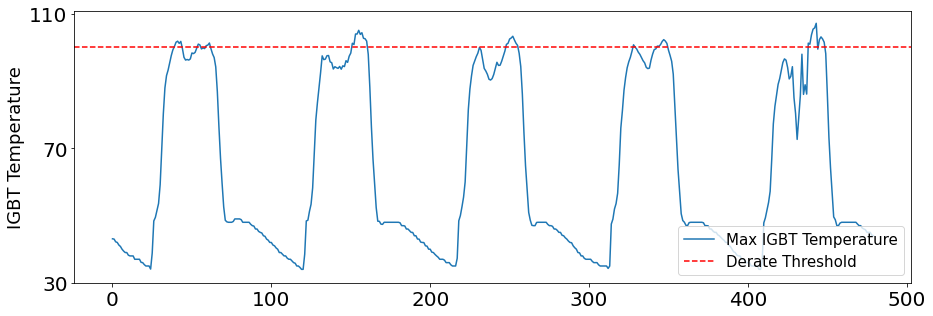

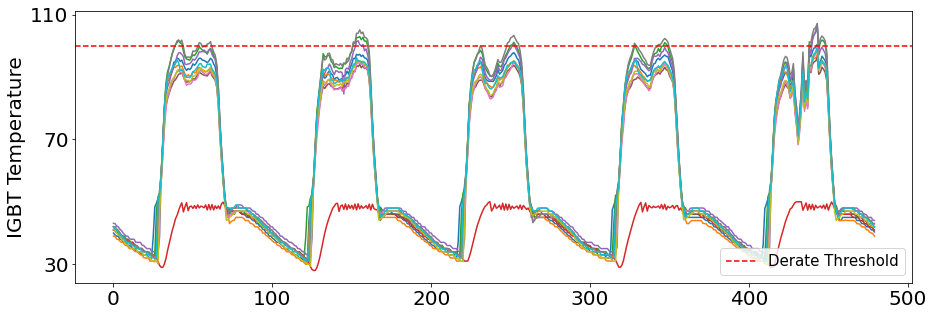

In [11]:
test_wo=test_result_wo.mean(1)
test_result_wo_np=test_result_wo.detach().cpu().numpy()
plt.figure(figsize=(15, 5.5))
visualization_period_1=4
visualization_period_2=9

length=(visualization_period_2-visualization_period_1)*96
subset=testX[-visualization_period_2*96:-visualization_period_1*96,4]
subset=subset.cpu().numpy()
aaa=np.where(subset>0.5)[0]/96
derate_plot=np.where(subset>0.5,0.5,0)
subset_irra=testX[-visualization_period_2*96:-visualization_period_1*96,3]
subset_irra=subset_irra.cpu().numpy()


plt.figure(figsize=(15, 5))
plt.plot(np.array(np.arange(len(derate_plot))),igbt_max_summer_test[-visualization_period_2*96:-visualization_period_1*96],label='Max IGBT Temperature')
plt.axhline(y=100,linestyle='dashed',color='red',label='Derate Threshold')
plt.yticks([30,70,110])
plt.ylabel("IGBT Temperature",fontsize=18)
plt.legend(loc='lower right',fontsize=15)
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(loc='lower right',fontsize=15)

plt.savefig('know_results/max_igbt.png')

# plt.ylim((-0.05, 1)) 
plt.show()


plt.figure(figsize=(15, 5))
for i in range(10):
    plt.plot(np.array(np.arange(len(derate_plot))),igbt_temp_summer_test[i,-visualization_period_2*96:-visualization_period_1*96])
plt.axhline(y=100,linestyle='dashed',color='red',label='Derate Threshold')
plt.yticks([30,70,110])
plt.ylabel("IGBT Temperature",fontsize=20)
plt.legend(loc='lower right')
# plt.ylim((-0.05, 1)) 
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(loc='lower right',fontsize=15)

plt.savefig('know_results/igbt.png')

plt.show()


# save without constraint model

In [17]:
# torch.save(net.state_dict(), './know_results/summer/solar_wo0216.pth')

In [29]:
# net.load_state_dict(torch.load('./know_results/summer/solar_wo.pth'))

<All keys matched successfully>

# generate constraint data

In [12]:
#P_W_data_inverterA=com_P_W_data[...,[0,1,2,5,7,8,9,10,11,12,13]] #InverterA_power,curtail_utility,curtail_on,TBOM,Tamb,    WS,ipoa,ipoa2,IGBT_derate_A,IGBT_off_A,watts,Feeder_indicater

#generate nonnegative constraint samples
non_nega_series=trainX[[38,7046,418,125,324,241,10298,432,15574,789,850],...].to(device)
#generate upper bound constraint samples
upper_limit_series=torch.tensor([[0.0, 0.0000, 0.0000, 0.9030, 1.0000, 0.0000, 1.0000,1, 0.6, 0.26],
                                 [0.0, 0.0000, 0.0000, 0.99, 1.0000, 0.0000, 1.0000,1, 0.5, 0.25],
                                  [0.0, 0.0000, 0.0000, 0.9030, 1.0000, 0.0000, 1.0000,1, 0.652, 0.9808],
                                  [0.0, 0.0000, 0.0000, 0.9030, 1.0000, 0.0000, 1.0000,1, 0.4842, 0.2137],
                                 [0.0, 0.0000, 0.0000, 0.89, 1.0000, 0.0000, 1.0000,1, 0.5895, 0.9008],
                                 [0.0, 0.0000, 0.0000, 0.9630, 0.0000, 0.0000, 1.0000,1, 0.4842, 0.2137],
                                  [0.0, 0.0000, 0.0000, 0.8386, 0.0000, 0.0000, 1.0000,1, 0.4842, 0.9808],
                                  [0.0, 0.0000, 0.0000, 0.8310, 0.0000, 0.0000, 1.0000, 1,0.5368, 0.2411]]).to(device)


#generate monotone constraint samples
mono_series=torch.tensor([[0.0, 0.0000, 0.0000, 0.07, 0.0000, 0.0000, 1.0000,1, 0.6,0.26],
                         [0.0, 0.0000, 0.0000, 0.08, 0.0000, 0.0000, 1.0000, 1,0.6,  0.26],
                         [0.0, 0.0000, 0.0000, 0.1,0.0000, 0.0000, 1.0000, 1,0.6, 0.26],
                         [0.0, 0.0000, 0.0000, 0.12, 0.0000, 0.0000, 1.0000,1, 0.6,  0.26],
                         [0.0, 0.0000, 0.0000, 0.65, 0.0000, 0.0000, 1.0000, 1,0.6, 0.26],
                         [0.0, 0.0000, 0.0000, 0.68, 0.0000, 0.0000, 1.0000, 1,0.6, 0.26],
                         [0.0, 0.0000, 0.0000, 0.81, 0.0000, 0.0000, 1.0000, 1,0.6, 0.26],
                         [0.0, 0.0000, 0.0000, 0.83, 0.0000, 0.0000, 1.0000, 1,0.6,0.26],]).to(device)

# exact_0_series=trainX[[35,7042,430,550,12440,9550,8390,11390,24070],...].to(device)
exact_0_series=torch.tensor([[0.0, 0.0000, 0.0000, 0.0000,0.0000, 0.0000, 0.0000, 0.0000, 0.8526,
         0.1589],
        [0.0, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.84,
         0.3589],
        [0.0, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.2,
         0.1699],
        [0.0, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.15,
         0.1753],
        [0.0, 0.0000, 0.0000, 0, 0.0000,0.0000,  0.0000, 0.0000, 0.12,
         0.1753],
        [0.0, 0.0000, 0.0000, 0.00, 0.0000, 0.0000, 0.0000,0, 0.1,0.26],
        [0.0, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.12,
         0.5151],
        [0.0, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.81,
         0.4301],
        [0.0, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.08,
         0.3973],
        [0.0, 0.0000, 0.0000, 0.0000,0.0000, 0.0000, 0.0000, 0.0000, 0.6,
         0.4849],
        [0.0, 0.0000, 0.0000, 0.0000,0.0000, 0.0000, 0.0000, 0.0000, 0.12,
         0.8466]]).to(device)


derate_series=torch.tensor([[0.0, 0.0000, 0.0000, 0.4030,  1.0000, 0.0000, 1.0000,1, 0.3, 0.26],
                            [0.0, 0.0000, 0.0000, 0.95,     1.0000, 0.0000, 1.0000,1, 0.5, 0.25],
                            [0.0, 0.0000, 0.0000, 0.6030,    1.0000, 0.0000, 1.0000,1, 0.652, 0.9808],
                            [0.0, 0.0000, 0.0000, 0.7030,   1.0000, 0.0000, 1.0000,1, 0.4842, 0.2137],
                            [0.0, 0.0000, 0.0000, 0.89,     1.0000, 0.0000, 1.0000,1, 1.5895, 0.9808],
                            [0.0, 0.0000, 0.0000, 0.9278, 1.0000, 0.0000, 1.0000, 1., 0.6211, 0.0055],
                            [0.0, 0.0000, 0.0000, 0.4030,  0.0000, 0.0000, 1.0000,1, 0.3, 0.26],
                            [0.0, 0.0000, 0.0000, 0.95,      0.0000, 0.0000, 1.0000,1, 0.5, 0.25],
                            [0.0, 0.0000, 0.0000, 0.6030,    0.0000, 0.0000, 1.0000,1, 0.652, 0.9808],
                            [0.0, 0.0000, 0.0000, 0.7030,   0.0000, 0.0000, 1.0000,1, 0.4842, 0.2137],
                            [0.0, 0.0000, 0.0000, 0.89,     0.0000, 0.0000, 1.0000,1, 0.5895, 0.9808],
                            [0.0, 0.0000, 0.0000, 0.9278, 0.0000, 0.0000, 1.0000, 1., 0.6211, 0.0055]]
                             ).to(device)
                            #curtail_utility,curtail_on,WS,ipoa,IGBT_derate_A,IGBT_off_A,watts,Feeder_indicater

In [21]:
# net.load_state_dict(torch.load('./know_results/summer/solar_wo0216.pth'))

<All keys matched successfully>

# train the model with derate constraint only

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
loss_func = torch.nn.MSELoss()  
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
# train the network
for t in range(160):
    train_loss=0
    train_complexity_loss=0
    non_negative_loss=0
    upper_lim_loss=0
    mono_loss=0
    exact_value_loss=0
    derate_loss=0
    if t>=3 and t<40:
        optimizer = torch.optim.Adam(net.parameters(), lr=0.0002)
    if t>=40:
        optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
    if t>=90:
        optimizer = torch.optim.Adam(net.parameters(), lr=0.00005)
   
    
    for i, (x, y) in enumerate(trainloader):
        prediction = net(x)     # input x and predict based on x
        loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)
        complexity_loss = kl_loss(net)
        optimizer.zero_grad()
        
        
        
        #Constraints
        non_nega_output=net(non_nega_series)
        up_lim_output=net(upper_limit_series)
        mono_output=net(mono_series)
        value_output=net(exact_0_series)
        derate_output=net(derate_series)
        non_nega_output[non_nega_output>0]=0
        con_non_negative=-1*torch.mean(non_nega_output)
        
        up_lim_output[up_lim_output<1.]=0
        con_upper_lim=torch.mean(up_lim_output)        
    
#         monotone
        mono_0=mono_output[:-1]
        mono_1=mono_output[1:]
        diff=mono_0-mono_1
        diff[diff<0]=0
        con_mono=torch.mean(diff)
        
        # exact 0 when ipoa=0:
        abs_value=torch.abs(value_output)
        con_value=torch.mean(abs_value)
        
        
        #derate mono:
        de_0=derate_output[:6]
        de_1=derate_output[6:]
        sub=de_0-de_1
        sub[sub<0]=0
        con_derate=torch.mean(sub)
        
        
        total_loss=0.000018*complexity_loss+loss+1*con_derate #con_upper_lim+con_mono++2*con_non_negative+2*con_value
#         total_loss=0.00002*complexity_loss+loss+5*(con_non_negative+con_mono+con_value)
        if t<3:
            total_loss=0.00002*complexity_loss+loss
        total_loss.backward()         # backpropagation, compute gradients
        
        train_loss += loss.item()*x.size(0)
        train_complexity_loss+= complexity_loss.item()*x.size(0)
        non_negative_loss+=con_non_negative
        upper_lim_loss+=con_upper_lim
        mono_loss+=con_mono
        exact_value_loss+=con_value
        derate_loss+=con_derate
        optimizer.step()
    train_loss_avg = train_loss/len(trainloader.sampler)
    train_complexity_loss_avg=train_complexity_loss/len(trainloader.sampler)
    non_negative_avg=non_negative_loss/(i+1)
    upper_lim_avg=upper_lim_loss/(i+1)
    mono_avg=mono_loss/(i+1)
    exact_value_avg=exact_value_loss/(i+1)
    derate_avg=derate_loss/(i+1)

    print('epoch:',t,'; loss: ',train_loss_avg,'complexity loss:',train_complexity_loss_avg,'non_negative:',non_negative_avg,'upper_lim:',upper_lim_avg,'mono:',mono_avg,'exact_value:',exact_value_avg,'derate_mono',derate_avg)


In [25]:
# torch.save(net.state_dict(), './know_results/summer/solar_derate0216.pth')

In [42]:
# net.load_state_dict(torch.load('./know_results/summer/solar_derate0215.pth'))

<All keys matched successfully>

In [13]:
net.load_state_dict(torch.load('./know_results/summer/solar_derate0216.pth'))

<All keys matched successfully>

In [14]:
#test
n_sample=50
test_loss=0.0
test_results_w=torch.zeros_like(testY)
test_result_w=test_results_w.repeat(1,n_sample)
test_loss_sample=0
net.eval()
for t in range(n_sample):
    test_loss=0.0
    for i, (data, target) in enumerate(testloader):
            # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
#         print(output.shape)
        # calculate the loss
        loss = loss_func(output, target)
        # update running validation loss
        test_loss += loss.item()*data.size(0)
        if data.size(0)==batch_size:
            test_result_w[batch_size*i:batch_size*(i+1),t]=output.squeeze()
        else:
            test_result_w[batch_size*i:,t]=output.squeeze()
    test_loss_avg = test_loss/len(testloader.sampler)
    test_loss_sample+=test_loss_avg
    print(test_loss_avg)
test_sample_avg_w=test_loss_sample/n_sample
print( 'loss: ',test_sample_avg_w)


0.0013202240224927664
0.0010450159898027778
0.001015238231047988
0.0010413664858788252
0.0010243133874610066
0.001173800672404468


0.0010367395589128137
0.0010732829105108976
0.0010251135099679232
0.0011378172785043716
0.0010025514056906104
0.001006942242383957
0.0010519280331209302


0.0010110068833455443
0.001005758997052908
0.0010258046677336097
0.0010432720882818103
0.0010655415244400501
0.0010096684563905
0.0010297494009137154


0.0011736537562683225
0.0010228746104985476
0.001104072667658329
0.0011486865114420652
0.0010390172246843576
0.001065553748048842
0.0010840247850865126


0.0009990695398300886
0.0010603315895423293
0.001036321627907455
0.0011711543193086982
0.0012039431603625417
0.0011021506506949663
0.001011716085486114


0.001005815458483994
0.001165099791251123
0.0010983963729813695
0.0010117428610101342
0.001039365422911942
0.0010438141180202365
0.0010165349813178182


0.0010686359601095319
0.0010677376994863153
0.001017366535961628
0.0011101457057520747
0.0010931547731161118


0.0010261271381750703
0.0010654526995494962
0.0011561342980712652
0.0012208962580189109
loss:  0.0010714825219474732


In [15]:
test_w=test_result_w.mean(1)
# plt.figure(figsize=(32, 6))
visualization_period_1=1
visualization_period_2=68
test_result_w_np=test_result_w.detach().cpu().numpy()
pred=test_w.cpu().detach().numpy()
true_value=testY.cpu().detach().numpy()
# plt.title('With Constraint')
# plt.plot(pred[-visualization_period_2*96:-visualization_period_1*96],label='pred')
# plt.plot(true_value[-visualization_period_2*96:-visualization_period_1*96,0],label='true')
# plt.legend()

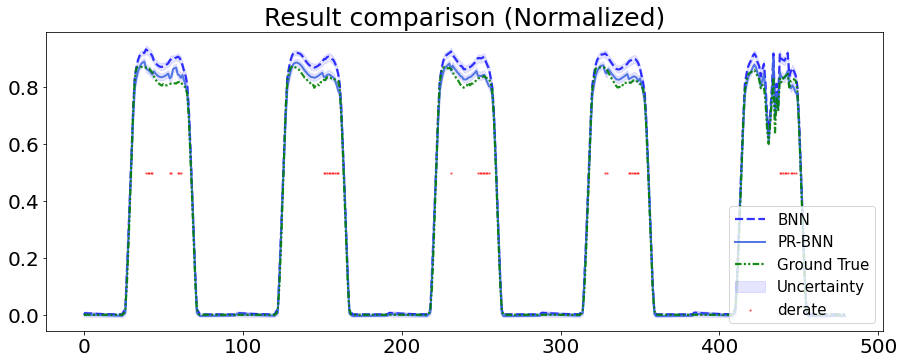

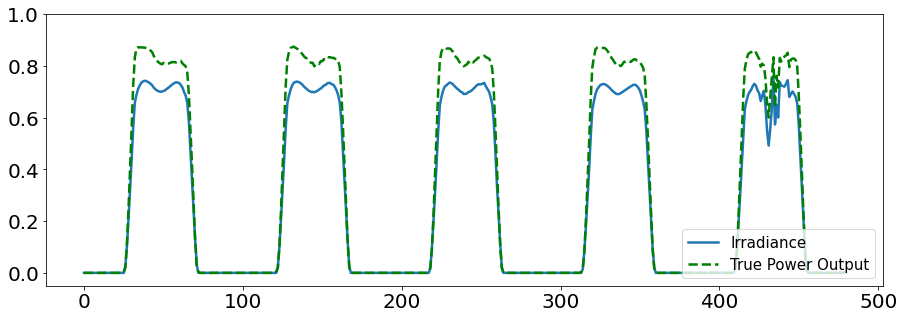

In [16]:

test_wo=test_result_wo.mean(1)
test_result_wo_np=test_result_wo.detach().cpu().numpy()
plt.figure(figsize=(15, 5.5))
visualization_period_1=4
visualization_period_2=9

length=(visualization_period_2-visualization_period_1)*96
subset=testX[-visualization_period_2*96:-visualization_period_1*96,4]
subset=subset.cpu().numpy()
aaa=np.where(subset>0.5)[0]/96
derate_plot=np.where(subset>0.5,0.5,0)
subset_irra=testX[-visualization_period_2*96:-visualization_period_1*96,3]
subset_irra=subset_irra.cpu().numpy()

pred=test_wo.cpu().detach().numpy()
pred_con=test_w.cpu().detach().numpy()
true_value=testY.cpu().detach().numpy()
# plt.title('Without Constraint')
plt.title('Result comparison (Normalized)',size = 25)

plt.plot(pred[-visualization_period_2*96:-visualization_period_1*96],label='BNN',linestyle='dashed',color='blue',alpha=0.8,linewidth=2.2)
plt.plot(pred_con[-visualization_period_2*96:-visualization_period_1*96],label='PR-BNN',color='royalblue',alpha=0.9,linewidth=2)

plt.plot(true_value[-visualization_period_2*96:-visualization_period_1*96,0],label='Ground True',linewidth=2.2,linestyle=(0,(3,1,1,1,1,1)),color='green',alpha=0.9)
plt.fill_between(np.arange(length), np.percentile(test_result_wo_np[-visualization_period_2*96:-visualization_period_1*96,:], 2.5,axis=1),np.percentile(test_result_wo_np[-visualization_period_2*96:-visualization_period_1*96,:], 97.5,axis=1), color='blue', alpha = 0.1, label="Uncertainty")
plt.fill_between(np.arange(length), np.percentile(test_result_w_np[-visualization_period_2*96:-visualization_period_1*96,:], 2.5,axis=1),np.percentile(test_result_w_np[-visualization_period_2*96:-visualization_period_1*96,:], 97.5,axis=1), color='blue', alpha = 0.1)
plt.scatter(np.array(np.where(subset>0.5)[0]),np.full(len(np.array(np.where(subset>0.5)[0])), 0.5),s=1.8,c='red',label='derate',alpha=0.5)
plt.legend(loc='lower right',fontsize=15)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.savefig('know_results/solar_prediction_comparison.pdf',format='pdf',bbox_inches="tight")

plt.show()

#plot iradiance

plt.figure(figsize=(15, 5))

plt.plot(np.array(np.arange(len(derate_plot))),subset_irra,label='Irradiance',linewidth=2.5)
plt.plot(true_value[-visualization_period_2*96:-visualization_period_1*96,0],label='True Power Output',linewidth=2.5,linestyle="dashed",color='green')
plt.legend(loc='lower right',fontsize=15)
plt.ylim((-0.05, 1))
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.savefig('know_results/irra_bnn.pdf',format='pdf',bbox_inches="tight")
plt.show()


### evaluations calculation



In [19]:
daytime_index=np.where((traj_test[:,-2]>0.3900)&(traj_test[:,-2]<0.7100))[0] #9:30 am-5 pm
print(daytime_index.shape)
peaktime_index=np.where((traj_test[:,-2]>0.42)&(traj_test[:,-2]<0.5800))[0] #10 am-2 pm
print(peaktime_index.shape)


test_w_day=test_w[daytime_index]
test_wo_day=test_wo[daytime_index]

test_w_peak=test_w[peaktime_index]
test_wo_peak=test_wo[peaktime_index]


# test_Y_day=(testY[daytime_index]).repeat(1,n_sample)
# test_Y_peak=(testY[peaktime_index]).repeat(1,n_sample)
test_Y_day=(testY[daytime_index,0])
test_Y_peak=(testY[peaktime_index,0])
test_w_result_day=test_result_w[daytime_index,:]
test_wo_result_day=test_result_wo[daytime_index,:]

test_w_result_peak=test_result_w[peaktime_index,:]
test_wo_result_peak=test_result_wo[peaktime_index,:]

loss_w_day=loss_func(test_w_day,test_Y_day)
loss_wo_day=loss_func(test_wo_day,test_Y_day)
loss_w_peak=loss_func(test_w_peak,test_Y_peak)
loss_wo_peak=loss_func(test_wo_peak,test_Y_peak)

print(" All time with constraint MSE : %6f, all time without constraint MSE: %6f" % (test_sample_avg_w,test_sample_avg_wo))
print("all time with constraint NRMSE : %6f, all time without constraint NRMSE: %6f" % (np.sqrt(test_sample_avg_w), np.sqrt(test_sample_avg_wo)))
print(" daytime with constraint MSE : %6f, daytime without constraint MSE: %6f" % (loss_w_day,loss_wo_day))
print("daytime with constraint NRMSE : %6f,daytime without constraint NRMSE: %6f" % (torch.sqrt(loss_w_day), torch.sqrt(loss_wo_day)))
print(" peak with constraint MSE : %6f, peak without constraint MSE: %6f" % (loss_w_peak,loss_wo_peak))
print("peaktime with constraint NRMSE : %6f, peaktime without constraint NRMSE: %6f" % (torch.sqrt(loss_w_peak), torch.sqrt(loss_wo_peak)))

(2040,)
(1088,)
 All time with constraint MSE : 0.001069, all time without constraint MSE: 0.001756
all time with constraint NRMSE : 0.032695, all time without constraint NRMSE: 0.041907
 daytime with constraint MSE : 0.002552, daytime without constraint MSE: 0.004518
daytime with constraint NRMSE : 0.050513,daytime without constraint NRMSE: 0.067219
 peak with constraint MSE : 0.001722, peak without constraint MSE: 0.003731
peaktime with constraint NRMSE : 0.041495, peaktime without constraint NRMSE: 0.061084


In [22]:
import hydrostats.ens_metrics as em
crps_dictionary_rand_wo = em.ens_crps(true_value[:,0], test_result_wo.cpu().detach().numpy())
crps_dictionary_rand_w = em.ens_crps(true_value[:,0], test_result_w.cpu().detach().numpy())
crps_w=crps_dictionary_rand_w['crpsMean']
crps_wo=crps_dictionary_rand_wo['crpsMean']
print('with constraint crps:',crps_w,'without constraint crps:',crps_wo)

crps_dictionary_rand_wo_day = em.ens_crps(true_value[:,0][daytime_index], test_result_wo[daytime_index,:].cpu().detach().numpy())
crps_dictionary_rand_w_day = em.ens_crps(true_value[:,0][daytime_index], test_result_w[daytime_index,:].cpu().detach().numpy())

crps_w_day=crps_dictionary_rand_w_day['crpsMean']
crps_wo_day=crps_dictionary_rand_wo_day['crpsMean']
print('with constraint crps day:',crps_w_day,'without constraint crps day:',crps_wo_day)

crps_dictionary_rand_wo_peak = em.ens_crps(true_value[:,0][peaktime_index], test_result_wo[peaktime_index,:].cpu().detach().numpy())
crps_dictionary_rand_w_peak = em.ens_crps(true_value[:,0][peaktime_index], test_result_w[peaktime_index,:].cpu().detach().numpy())

crps_w_peak=crps_dictionary_rand_w_peak['crpsMean']
crps_wo_peak=crps_dictionary_rand_wo_peak['crpsMean']

print('with constraint crps peak:',crps_w_peak,'without constraint crps peak:',crps_wo_peak)

with constraint crps: 0.011422481959018847 without constraint crps: 0.01868947739901741
with constraint crps day: 0.023291362338250174 without constraint crps day: 0.04477372793315965
with constraint crps peak: 0.02116968086704831 without constraint crps peak: 0.045000068600289524
